# Basic GW Example

This notebook contains an example describing how to look for the gravitational wave counterpart in Fermi-GBM data. 

As first step, we load the gravitational wave localization map into memory by means of the skymap module of the gamma-ray data tools (GDT) package. The new Healpix object will have a resolution of minimum nside = 128, to match the native resolution of the Fermi-GBM skymap. Currently, multiresolution maps are not supported, so the keyword **flatten** to flatten a multiorder skymap is set to **False**. Multiorder support will come in the future. The localization map of the gravitational wave event will be combined with the Fermi-GBM localization map to produce a joint localization map at the end of this example.

The new LigoHealPix object that we create contains the time of the gravitational wave event. We will use the format **datetime** to create a new Time object from this field. This information can be used to retrieve the data the Fermi-GBM observed during the gravitational wave event, as well as to specify the time interval over which the search will be made.

In [15]:
import skymap 
import datetime
import urllib.request
from gdt.missions.fermi.time import Time

# download the preliminary map for GW170817
url = 'https://dcc.ligo.org/public/0146/G1701985/001/preliminary-LALInference.fits.gz'
urllib.request.urlretrieve(url, 'GW170817-preliminary-LALInference.fits.gz')

gwskymap = skymap.LigoHealPix.open('GW170817-preliminary-LALInference.fits.gz', min_nside=128, flatten=False)
trigtime_datetime = datetime.datetime.fromisoformat(gwskymap.trigtime)
trigtime = Time(trigtime_datetime, format='datetime')

The Fermi-GBM data employed in this analysis are the continuous time tagged events detected during the gravitational wave event. They are downloaded using the ContinuousFtp class from the Fermi GBM mission API available in the Gamma-ray Data Tools (GDT).

In [16]:
import glob
from gdt.missions.fermi.gbm.finders import ContinuousFtp

ftp = ContinuousFtp(trigtime)

# download TTE
ftp.get_tte("data/gbm", dets=['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9', 'na', 'nb'])
tte_files = sorted(glob.glob('data/gbm/glg_tte_n?_170817_12z_v??.fit.gz'))

# download spacecraft position history
ftp.get_poshist('data/gbm')
poshist_file = glob.glob('data/gbm/glg_poshist_all_170817_v??.fit')[-1]

# summary of local files
print("Downloaded TTE files:")
for file in tte_files:
    print(f"  {file}")
print(f"\nDownloaded PosHist file: {poshist_file}")

glg_poshist_all_170817_v01.fit ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╺━━━━ 89.5% • 8.2/9.2 MB • 11.1 MB/s • 0:00:01

Downloaded TTE files:
  data/gbm/glg_tte_n0_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n1_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n2_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n3_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n4_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n5_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n6_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n7_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n8_170817_12z_v00.fit.gz
  data/gbm/glg_tte_n9_170817_12z_v00.fit.gz
  data/gbm/glg_tte_na_170817_12z_v00.fit.gz
  data/gbm/glg_tte_nb_170817_12z_v00.fit.gz

Downloaded PosHist file: data/gbm/glg_poshist_all_170817_v01.fit


Now we load the data into memory.

In [17]:
from gdt.missions.fermi.gbm.tte import GbmTte

tte_data = []
for tte_file in tte_files:
    tte = GbmTte.open(tte_file)
    tte_data.append(tte)

Let us bin the data into a PHAII format, specifying the time of the observation in Fermi Mission Elapse Time. This value will be used to phase the data with respect to the time of the observation.

In [18]:
import gts

channel_edges = [8, 20, 33, 51, 85, 106, 127]
pha2_data = gts.preparePha2Data(tte_data, channel_edges, t0=trigtime.fermi, time_range=[-30, 30])

We load the direct responses of the detectors.

In [19]:
kwargs = {'templates': [0, 1, 2], 'channels': [1, 2, 3, 4, 5, 6]}
response = gts.loadResponse('templates/GBM/direct/nai.npy', **kwargs)

Let us retrieve the position history information of the Fermi spacecraft. This will be useful for example to determine the Earth position in spacecraft coordinates, and appropriately load an additional component to the response to account for the atmospheric scattering. 

In [20]:
import utils
from gdt.missions.fermi.gbm.poshist import GbmPosHist

poshist = GbmPosHist.open('data/gbm/glg_poshist_all_170817_v01.fit')
spacecraft_frames = poshist.get_spacecraft_frame()

az, zen = utils.getGeoCoordinates(spacecraft_frames.at(trigtime), unit='deg')[:2]
print("Location of Earth Center in Spacecraft Frame:")
print(" - Azimuth %.1f deg" % az)
print(" - Zenith  %.1f deg" % zen)

Location of Earth Center in Spacecraft Frame:
 - Azimuth 140.2 deg
 - Zenith  130.0 deg


Now add the atmospheric scattering response using the file for this azimuth and zenith location of the Earth center.

In [21]:
response += gts.loadResponse('templates/GBM/atmo_nai/atmrates_az140_zen130.npy', **kwargs)

Let us specify the time window around **trigtime** where the search will be run, and some other useful settings. Then, run the search.

In [22]:
settings = {}   
settings['win_width'] = 10           # Window around T0 to search: search is run between T0-width/2 and T0+width/2
settings['min_dur'] = 0.064          # Minimum search duration
settings['max_dur'] = 8.192          # Maximum search duration
settings['min_step'] = 0.064         # Minimum phase shift
settings['num_steps'] = 8            # Number of phase shifts
settings['resolution'] = 0.512       # Unused. Need to implement sliding window background first.
settings['min_loglr'] = 5            # Minimum loglr to produce plots

search = gts.runSearch(pha2_data, response, spacecraft_frames, trigtime, background_range=[-30, 30], settings=settings)

Using custom search parameters:

Window around T0 to search:	 10 sec
Minimum search duration:	 0.064 sec
Maximum search duration:	 8.192 sec
Minimum phase step:		 0.064 sec
Number of phase steps:		 8
Minimum loglr to produce plots:	 5

Fitting backgrounds...
Background fit selection: -30 sec to 30 sec

Stat/DOF:
--------------------------- Channels ---------------------------
   1.04    0.95    0.97    1.01    0.85    0.86
   0.94    1.08    0.99    1.02    0.74    0.87
   1.05    0.96    0.97    0.95    0.84    0.82
   1.04    0.99    1.03    1.05    0.84    0.86
   1.01    1.07    0.99    0.93    0.81    0.93
   0.96    1.04    1.03    1.00    0.83    0.98
   0.94    0.97    1.00    1.06    0.80    0.98
   1.00    1.06    1.03    1.04    0.88    0.86
   0.94    0.97    0.96    0.99    0.76    0.87
   0.96    1.00    0.99    1.08    0.85    1.06
   0.98    1.01    1.01    0.96    0.86    0.96
   1.03    0.94    1.03    0.99    0.89    0.78

Running search...
Progress: 99%   
Done.

Se

Let us produce the Waterfall plot for the current results.

/Users/jrwood2/Software/GBM/gts/plots.py:349: RuntimeWarning: invalid value encountered in log
  color_fracs = np.log(vals-min_val)/np.log(max_val-min_val)


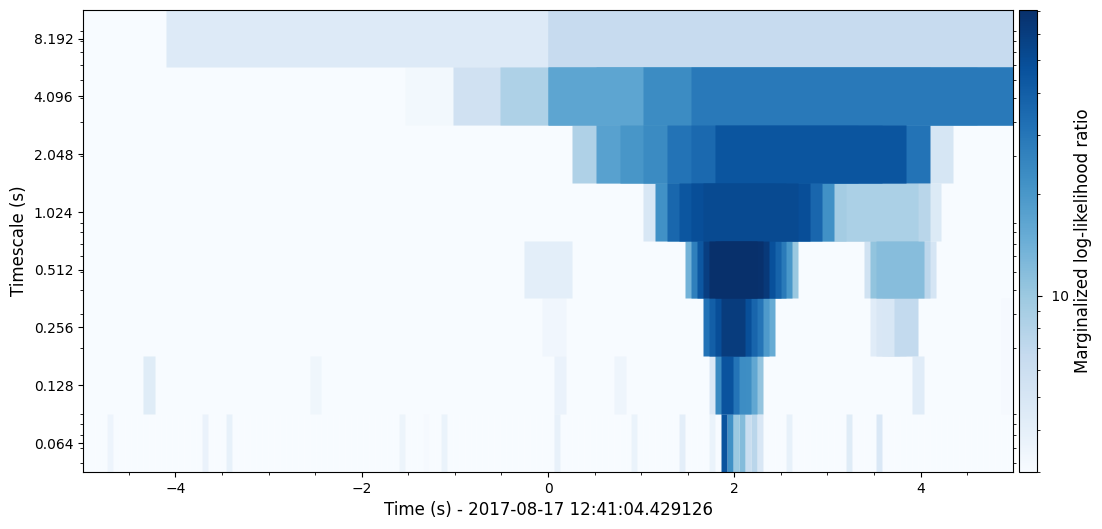

In [23]:
import plots

w = plots.Waterfall(search['results'], trigtime)
w.plot_loglr(val_min=3.0)

And display the results for the top candidates.

In [24]:
filtered_results = search['results']
filtered_results = filtered_results.downselect(threshold=5, no_empty=True)
filtered_results = filtered_results.downselect(combine_spec=False, fixedwin=5.0)
filtered_results.write()

Total number of bins: 2
In GTI: 2
Used atmoscat: 0
Pre-filtered: 0
--------------------------------------------------------------------------------------------------------------------------------------------------
    tcent    duration  gti rock good  phi  theta  ra  dec  spec ampli  snr  snr0  snr1 chisq chisq+ sun  earth    logLR   coincLR  PE0   PE1   PE2
--------------------------------------------------------------------------------------------------------------------------------------------------
        1.984   0.512   1    0    1    0.0  85.0 147.5 -37.8 1  1.10  12.4   6.1   6.6   0.9   1.3  51.1 130.1    70.65    71.02   3.2   3.0   1.7
        3.072   2.048   1    0    1  295.5  70.0  89.3  -1.6 2  0.20   7.9   3.9   4.3   1.2   0.8  59.0 150.7    25.63    26.00   4.0   2.7   3.6


Let us collect important information for the top candidate after filtering.

In [25]:
atmoscat = 1 # set to 1 because we used atmospheric scattering component in the response
tcent = filtered_results.times[0] 
duration = filtered_results.durations[0]
zen = filtered_results.locs_sc[1][0] 
template = filtered_results.templates[0] 

We can now plot the candidate lightcurve using summed counts from all detectors.

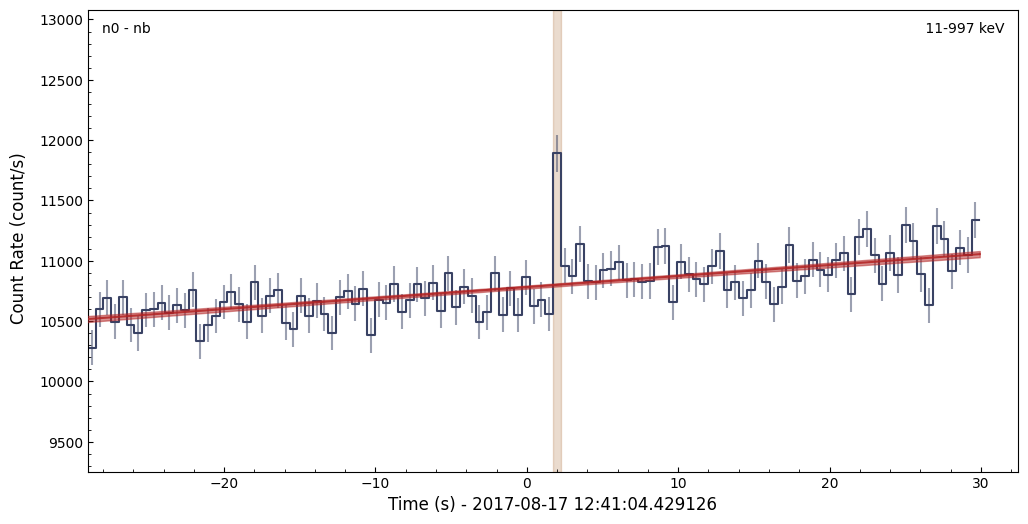

In [26]:
lcplotter = plots.TargetedLightcurves(search['data'], search['background'], trigtime)
lcplotter.plot_summed(duration, None, event_time=tcent - 0.5 * duration)

We can also create a localization, including a typical systematic error.

In [27]:
from gdt.missions.fermi.gbm.localization import GbmHealPix

systematic = (skymap.O3_DGAUSS_Model, atmoscat, zen) 
loc = gts.createLocalization(tcent, duration, template, search, GbmHealPix, systematic, remove_earth=True)

Now plot the localization.

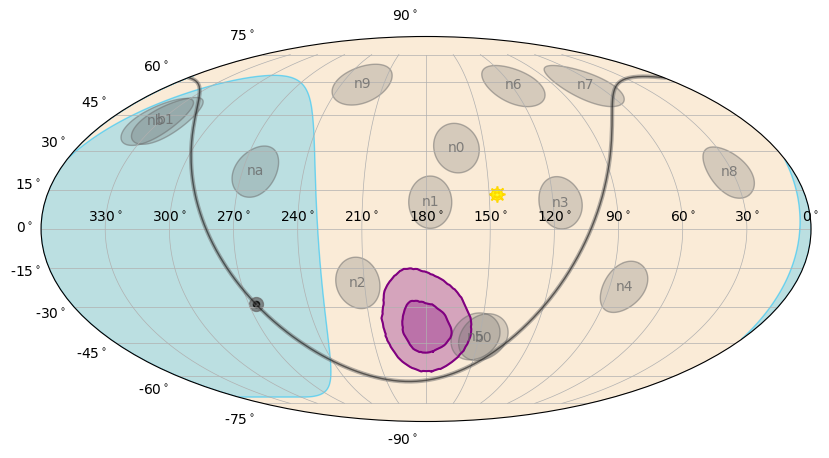

In [28]:
from gdt.core.plot.sky import EquatorialPlot

skyplot = EquatorialPlot()
skyplot.add_localization(loc, clevels=[0.90, 0.50], gradient=False)

Let us combine the resulting Fermi-GBM localization for the top candidate event with the LIGO/Virgo localization of the gravitational wave event. We can compute the spatial association between the two maps, and show the combined localization in a plot.

	 Event 1 Spatial Association: 92.3%


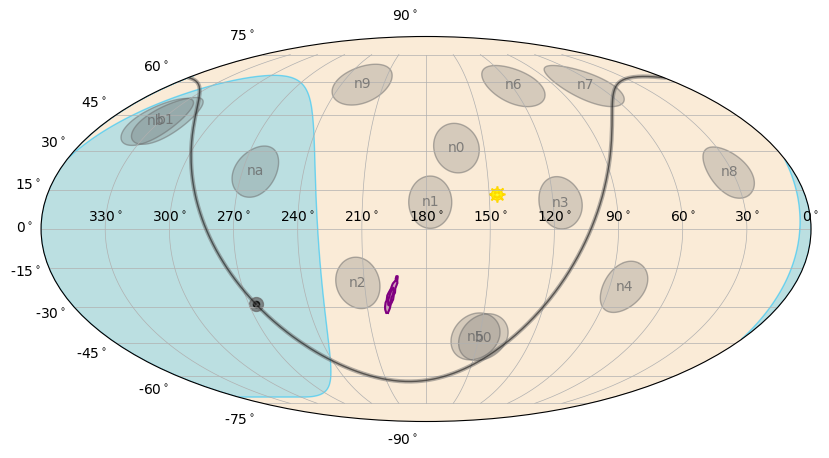

In [29]:
region_prob = loc.region_probability(gwskymap) * 100.0
print('\t Event {0} Spatial Association: {1:3.1f}%'.format(1, region_prob))

combined = loc.multiply(loc, gwskymap)
combined = GbmHealPix.from_data(combined.prob, trigtime=loc.trigtime, scpos=loc.scpos, quaternion=loc.quaternion)
skyplot = EquatorialPlot()
skyplot.add_localization(combined, clevels=[0.9, 0.5], gradient=False)